## 점진적 prophet

### 라이브러리 호출 및 데이터 준비

In [1]:
# 라이브러리 호출  

import pandas as pd  
import numpy as np  
from sklearn.preprocessing import StandardScaler 
import prophet 
import holidays 
from prophet import Prophet 
from prophet.plot import add_changepoints_to_plot 
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error 
import matplotlib.pyplot as plt

c:\Users\dlwlg\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 데이터 호출
df = pd.read_csv("C:/Users/dlwlg/Desktop/final/머신러닝/머신러닝용_시계열데이터_초안.csv", encoding='cp949')

In [3]:
# 기존 df에서 prophet 용으로 칼럼이름 수정 ( 날짜 > df / 총생활인구수 > y )
df = df.rename(columns={'날짜': 'ds', '총_결제금액': 'y'})

# 학습할 자치구 한정
test_df = df[df['자치구'] == '강남구']
test_df.drop(columns='자치구',inplace=True)

# 날짜 obj > datetime
test_df['ds'] = pd.to_datetime(test_df['ds'], errors='coerce')

# 사용하지 못하는 202001~202004, 202405~ 데이터 drop + 인덱스 초기화
test_df = test_df[(test_df['ds'] >= '2020-05-01') & (test_df['ds'] <= '2024-05-01')]
test_df = test_df.reset_index(drop=True)

C:\Users\dlwlg\AppData\Local\Temp\ipykernel_4500\474613604.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.drop(columns='자치구',inplace=True)
C:\Users\dlwlg\AppData\Local\Temp\ipykernel_4500\474613604.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['ds'] = pd.to_datetime(test_df['ds'], errors='coerce')


In [4]:
# 이상치 값 처리하기
def adjust_outliers(df, column):
    # IQR 방법을 사용하여 이상치 감지
    Q1 = df[column].quantile(0.3)
    Q3 = df[column].quantile(0.7)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # 이상치 값을 상한값(upper_bound)으로 조정
    df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])   
    return df

test_df = adjust_outliers(test_df,'y')

### 모델링 준비

In [5]:
# 한국 휴일 객체 생성
kr_holidays = holidays.KR()
min_date = test_df['ds'].min()
max_date = test_df['ds'].max()
future_date = max_date + pd.Timedelta(days=365)
full_date_range = pd.date_range(start=min_date, end=future_date)

# 학습 데이터 공휴일 칼럼  
holiday_df = pd.DataFrame(columns=['ds','holiday'])
holiday_df['ds'] = sorted(full_date_range)
holiday_df['holiday'] = holiday_df.ds.apply(lambda x: kr_holidays.get(x) if x in kr_holidays else 'non-holiday')

In [6]:
# 필요한 칼럼들만 필터링
selected_columns = ['ds','y']
test_df = test_df[selected_columns]

### 모델 학습

In [7]:
# 평가지표를 저장할 리스트
metrics = {'date': [], 'mape': [], 'mae': [], 'mse': []}
predictions = {'date': [], 'predicted': [], 'actual': []}

# 예측 시작일과 종료일
train_start = pd.to_datetime('2020-05-01')
train_end = pd.to_datetime('2024-04-01')

In [8]:
for i in range((pd.to_datetime('2024-05-01') - train_end).days):
    # 학습 데이터 준비 (train_end까지)
    train_data = test_df[(test_df['ds'] >= train_start) & (test_df['ds'] <= train_end)]
    
    # Prophet 모델 학습
    model = Prophet(holidays=holiday_df)
    model.fit(train_data)

    # 예측할 날짜 준비
    future = model.make_future_dataframe(periods=1)
    
    # 예측 수행
    forecast = model.predict(future)
    predicted_value = forecast.iloc[-1]['yhat']

    # 실제값과 예측값 비교
    actual_value = test_df[test_df['ds'] == train_end + pd.Timedelta(days=1)]['y'].values[0]

    # 평가지표 계산
    mape = mean_absolute_percentage_error([actual_value], [predicted_value])
    mae = mean_absolute_error([actual_value], [predicted_value])
    mse = mean_squared_error([actual_value], [predicted_value])

    # 결과 저장
    metrics['date'].append(train_end + pd.Timedelta(days=1))
    metrics['mape'].append(mape)
    metrics['mae'].append(mae)
    metrics['mse'].append(mse)

    # 예측값과 실제값 저장
    predictions['date'].append(train_end + pd.Timedelta(days=1))
    predictions['predicted'].append(predicted_value)
    predictions['actual'].append(actual_value)

    # 다음 예측을 위한 학습 데이터 확장
    train_end = train_end + pd.Timedelta(days=1)

# 결과 데이터프레임 생성
metrics_df = pd.DataFrame(metrics)
predictions_df = pd.DataFrame(predictions)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling daily seasonality. Run 

### 시각화 및 평가

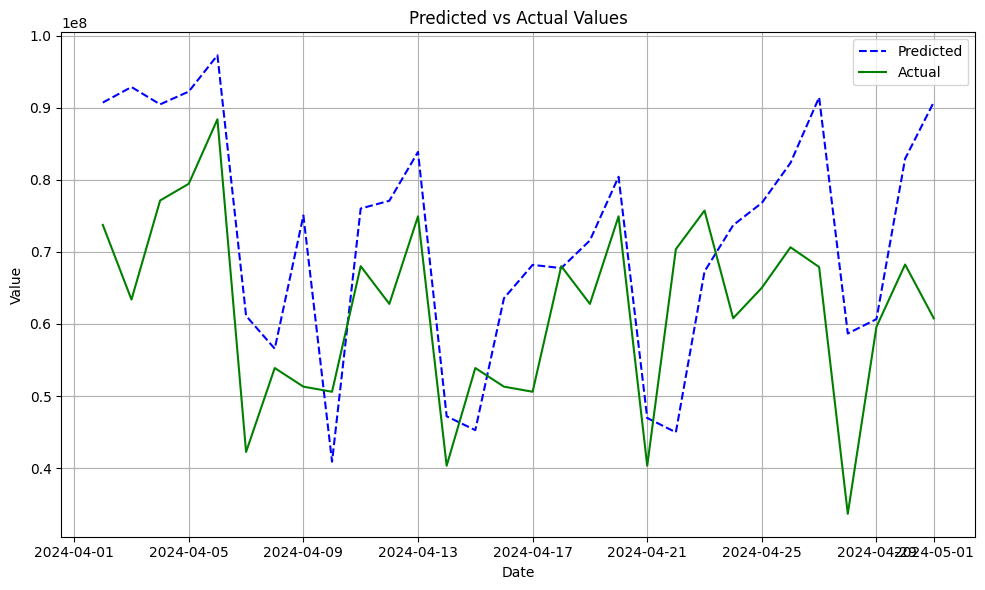

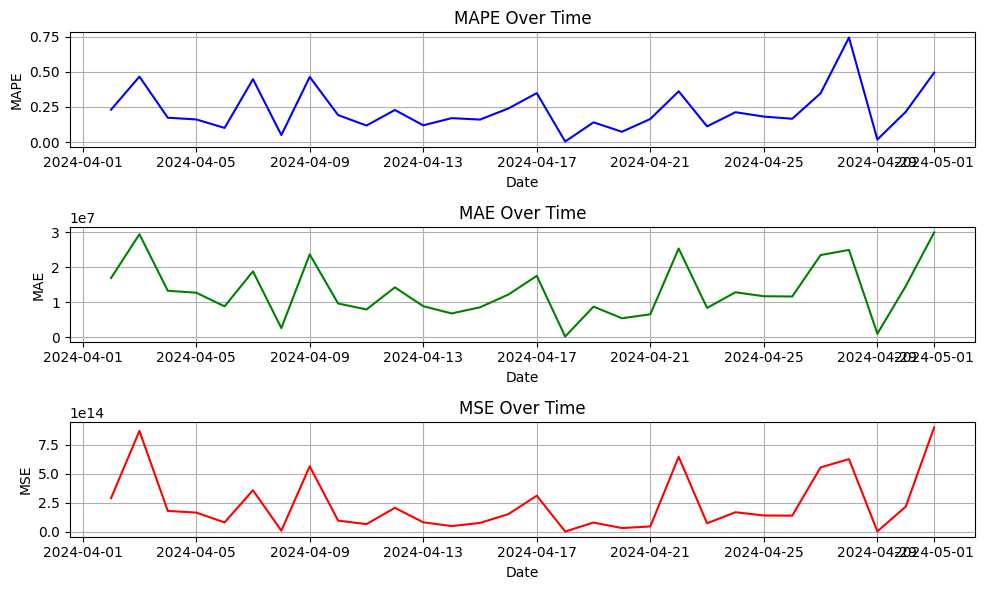

In [9]:
# 예측값과 실제값 비교 시각화
plt.figure(figsize=(10, 6))

# 예측값과 실제값 비교 그래프
plt.plot(predictions_df['date'], predictions_df['predicted'], color='blue', label='Predicted', linestyle='--')
plt.plot(predictions_df['date'], predictions_df['actual'], color='green', label='Actual')
plt.title('Predicted vs Actual Values')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

# 그래프 표시
plt.tight_layout()
plt.show()

# 평가지표 변화 시각화
plt.figure(figsize=(10, 6))

# MAPE 그래프
plt.subplot(3, 1, 1)
plt.plot(metrics_df['date'], metrics_df['mape'], color='blue', label='MAPE')
plt.title('MAPE Over Time')
plt.xlabel('Date')
plt.ylabel('MAPE')
plt.grid(True)

# MAE 그래프
plt.subplot(3, 1, 2)
plt.plot(metrics_df['date'], metrics_df['mae'], color='green', label='MAE')
plt.title('MAE Over Time')
plt.xlabel('Date')
plt.ylabel('MAE')
plt.grid(True)

# MSE 그래프
plt.subplot(3, 1, 3)
plt.plot(metrics_df['date'], metrics_df['mse'], color='red', label='MSE')
plt.title('MSE Over Time')
plt.xlabel('Date')
plt.ylabel('MSE')
plt.grid(True)

# 레이아웃 조정
plt.tight_layout()
plt.show()

## 점진적 prophet regressor

### 라이브러리 호출 및 데이터 준비

In [ ]:
# 데이터 재호출
df = pd.read_csv("C:/Users/dlwlg/Desktop/final/머신러닝/머신러닝용_시계열데이터_초안.csv", encoding='cp949')

In [13]:
# 기존 df에서 prophet 용으로 칼럼이름 수정 ( 날짜 > df / 총생활인구수 > y )
df = df.rename(columns={'날짜': 'ds', '총_결제금액': 'y'})

# 학습할 자치구 한정
test_df = df[df['자치구'] == '강남구']
test_df.drop(columns='자치구',inplace=True)

# 날짜 obj > datetime + 연, 월, 일 생성. 
test_df['ds'] = pd.to_datetime(test_df['ds'], errors='coerce')
test_df['연'] = test_df['ds'].dt.year
test_df['월'] = test_df['ds'].dt.month
test_df['일'] = test_df['ds'].dt.day

# 사용하지 못하는 202001~202004, 202405~ 데이터 drop + 인덱스 초기화
test_df = test_df[(test_df['ds'] >= '2020-05-01') & (test_df['ds'] <= '2024-05-01')]
test_df = test_df.reset_index(drop=True)

C:\Users\dlwlg\AppData\Local\Temp\ipykernel_4500\1020375637.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.drop(columns='자치구',inplace=True)
C:\Users\dlwlg\AppData\Local\Temp\ipykernel_4500\1020375637.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['ds'] = pd.to_datetime(test_df['ds'], errors='coerce')
C:\Users\dlwlg\AppData\Local\Temp\ipykernel_4500\1020375637.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

In [14]:
# 이상치 값 처리하기
def adjust_outliers(df, column):
    # IQR 방법을 사용하여 이상치 감지
    Q1 = df[column].quantile(0.3)
    Q3 = df[column].quantile(0.7)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # 이상치 값을 상한값(upper_bound)으로 조정
    df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])   
    return df

test_df = adjust_outliers(test_df,'y')

### 모델링 준비

In [15]:
# 한국 휴일 객체 생성
kr_holidays = holidays.KR()
min_date = test_df['ds'].min()
max_date = test_df['ds'].max()
future_date = max_date + pd.Timedelta(days=365)
full_date_range = pd.date_range(start=min_date, end=future_date)

# 학습 데이터 공휴일 칼럼  
holiday_df = pd.DataFrame(columns=['ds','holiday'])
holiday_df['ds'] = sorted(full_date_range)
holiday_df['holiday'] = holiday_df.ds.apply(lambda x: kr_holidays.get(x) if x in kr_holidays else 'non-holiday')

In [16]:
# 필요한 칼럼들만 필터링
selected_columns = ['ds','y','연','월','일']
test_df = test_df[selected_columns]

# regressor 칼럼 만들기
regressors = ['연','월','일']

### 모델 학습

In [17]:
# 평가지표를 저장할 리스트
metrics = {'date': [], 'mape': [], 'mae': [], 'mse': []}
predictions = {'date': [], 'predicted': [], 'actual': []}

# 예측 시작일과 종료일
train_start = pd.to_datetime('2020-05-01')
train_end = pd.to_datetime('2024-04-01')

In [18]:
for i in range((pd.to_datetime('2024-05-01') - train_end).days):
    # 학습 데이터 준비 (train_end까지)
    train_data = test_df[(test_df['ds'] >= train_start) & (test_df['ds'] <= train_end)]
    
    # Prophet 모델 학습
    model = Prophet(holidays=holiday_df)
    for regressor in regressors:
        model.add_regressor(regressor)
    model.fit(train_data)

    # 예측할 날짜 준비
    future = model.make_future_dataframe(periods=1)
    future['연'] = future['ds'].dt.year
    future['월'] = future['ds'].dt.month
    future['일'] = future['ds'].dt.day
    
    # 예측 수행
    forecast = model.predict(future)
    predicted_value = forecast.iloc[-1]['yhat']

    # 실제값과 예측값 비교
    actual_value = test_df[test_df['ds'] == train_end + pd.Timedelta(days=1)]['y'].values[0]

    # 평가지표 계산
    mape = mean_absolute_percentage_error([actual_value], [predicted_value])
    mae = mean_absolute_error([actual_value], [predicted_value])
    mse = mean_squared_error([actual_value], [predicted_value])

    # 결과 저장
    metrics['date'].append(train_end + pd.Timedelta(days=1))
    metrics['mape'].append(mape)
    metrics['mae'].append(mae)
    metrics['mse'].append(mse)

    # 예측값과 실제값 저장
    predictions['date'].append(train_end + pd.Timedelta(days=1))
    predictions['predicted'].append(predicted_value)
    predictions['actual'].append(actual_value)

    # 다음 예측을 위한 학습 데이터 확장
    train_end = train_end + pd.Timedelta(days=1)

# 결과 데이터프레임 생성
metrics_df_r = pd.DataFrame(metrics)
predictions_df_r = pd.DataFrame(predictions)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling daily seasonality. Run 

### 시각화 및 평가

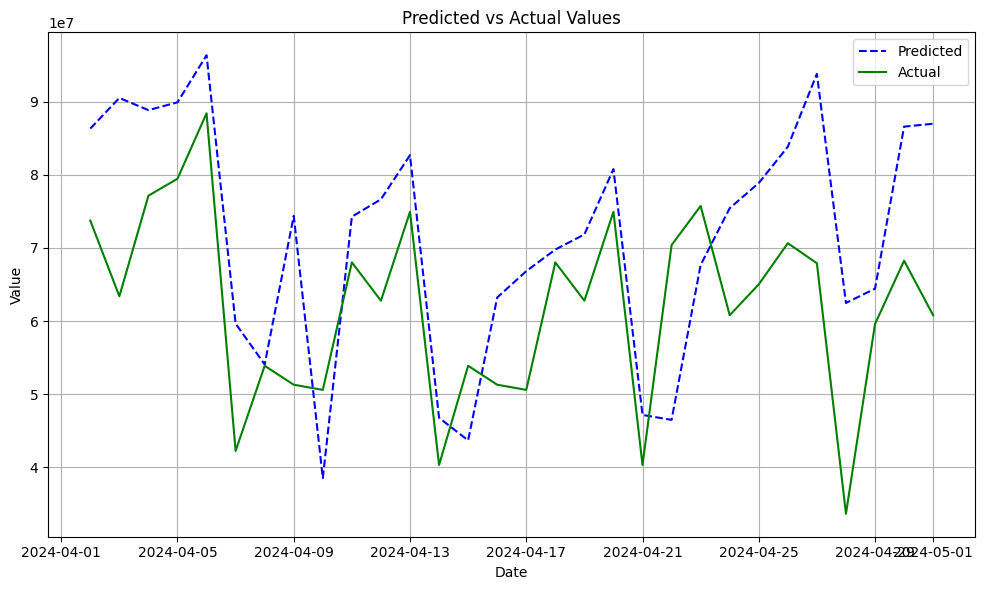

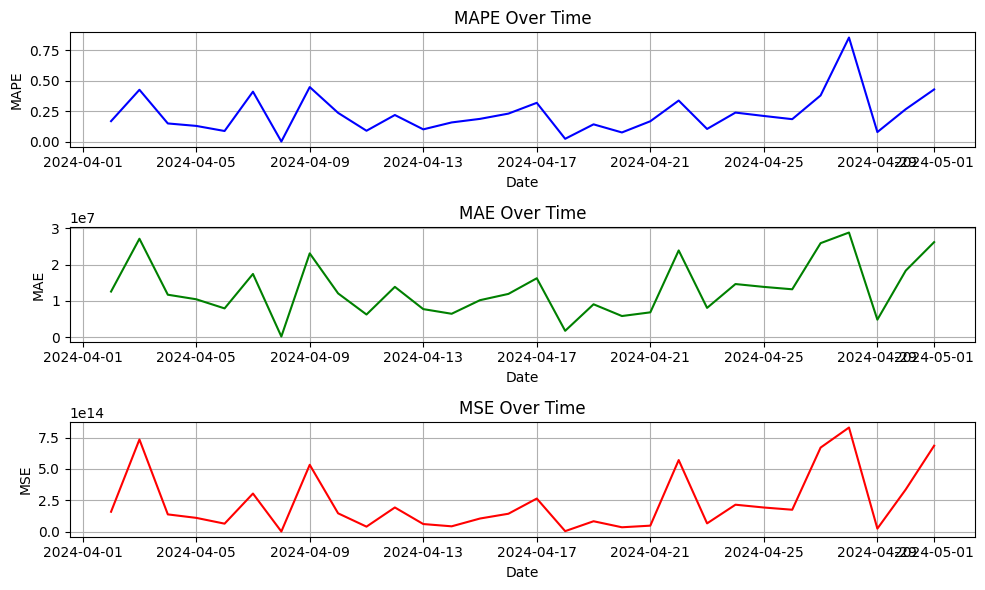

In [19]:
# 예측값과 실제값 비교 시각화
plt.figure(figsize=(10, 6))

# 예측값과 실제값 비교 그래프
plt.plot(predictions_df_r['date'], predictions_df_r['predicted'], color='blue', label='Predicted', linestyle='--')
plt.plot(predictions_df_r['date'], predictions_df_r['actual'], color='green', label='Actual')
plt.title('Predicted vs Actual Values')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

# 그래프 표시
plt.tight_layout()
plt.show()

# 평가지표 변화 시각화
plt.figure(figsize=(10, 6))

# MAPE 그래프
plt.subplot(3, 1, 1)
plt.plot(metrics_df_r['date'], metrics_df_r['mape'], color='blue', label='MAPE')
plt.title('MAPE Over Time')
plt.xlabel('Date')
plt.ylabel('MAPE')
plt.grid(True)

# MAE 그래프
plt.subplot(3, 1, 2)
plt.plot(metrics_df_r['date'], metrics_df_r['mae'], color='green', label='MAE')
plt.title('MAE Over Time')
plt.xlabel('Date')
plt.ylabel('MAE')
plt.grid(True)

# MSE 그래프
plt.subplot(3, 1, 3)
plt.plot(metrics_df_r['date'], metrics_df_r['mse'], color='red', label='MSE')
plt.title('MSE Over Time')
plt.xlabel('Date')
plt.ylabel('MSE')
plt.grid(True)

# 레이아웃 조정
plt.tight_layout()
plt.show()